# Clustering Analysis of Kubernetes Logs

This notebook implements and compares K-means, Hierarchical clustering, and DBSCAN algorithms on Kubernetes logs features, including benchmarking and performance evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Feature Sets

In [2]:
# Load feature sets from feature extraction
import json
import os

def load_feature_sets():
    """Load all prepared feature sets"""
    feature_sets = {}
    
    # Define file mappings
    files = {
        'scaled_features': 'features_scaled_features.csv',
        'pca_features': 'features_pca_features.csv',
        'selected_features': 'features_selected_features.csv',
        'numerical_only': 'features_numerical_only.csv'
    }
    
    for name, filename in files.items():
        try:
            if os.path.exists(filename):
                feature_sets[name] = pd.read_csv(filename)
                print(f"Loaded {name}: {feature_sets[name].shape}")
            else:
                print(f"File {filename} not found, creating sample data for {name}")
                # Create sample data for demonstration
                np.random.seed(42)
                if name == 'scaled_features':
                    feature_sets[name] = pd.DataFrame(
                        np.random.randn(1000, 10),
                        columns=[f'feature_{i}' for i in range(10)]
                    )
                elif name == 'pca_features':
                    feature_sets[name] = pd.DataFrame(
                        np.random.randn(1000, 5),
                        columns=[f'PC{i+1}' for i in range(5)]
                    )
                elif name == 'selected_features':
                    feature_sets[name] = pd.DataFrame(
                        np.random.randn(1000, 20),
                        columns=[f'selected_feature_{i}' for i in range(20)]
                    )
                elif name == 'numerical_only':
                    feature_sets[name] = pd.DataFrame(
                        np.random.randn(1000, 8),
                        columns=[f'numerical_feature_{i}' for i in range(8)]
                    )
        except Exception as e:
            print(f"Error loading {name}: {e}")
    
    return feature_sets

# Load feature sets
feature_sets = load_feature_sets()

print(f"\nLoaded {len(feature_sets)} feature sets:")
for name, features in feature_sets.items():
    print(f"  {name}: {features.shape}")

Loaded scaled_features: (57133, 112)
Loaded pca_features: (57133, 13)
Loaded selected_features: (57133, 21)
Loaded numerical_only: (57133, 13)

Loaded 4 feature sets:
  scaled_features: (57133, 112)
  pca_features: (57133, 13)
  selected_features: (57133, 21)
  numerical_only: (57133, 13)


## 2. Clustering Algorithm Implementation

In [3]:
# K-means clustering implementation
def perform_kmeans_clustering(features, k_range=(2, 11)):
    """Perform K-means clustering with different k values"""
    
    results = {}
    
    # Test different values of k
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        
        # Calculate metrics
        silhouette = silhouette_score(features, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(features, cluster_labels)
        davies_bouldin = davies_bouldin_score(features, cluster_labels)
        inertia = kmeans.inertia_
        
        results[k] = {
            'model': kmeans,
            'labels': cluster_labels,
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski_harabasz,
            'davies_bouldin_score': davies_bouldin,
            'inertia': inertia,
            'n_clusters': len(np.unique(cluster_labels))
        }
    
    return results

# Hierarchical clustering implementation
def perform_hierarchical_clustering(features, n_clusters_range=(2, 11)):
    """Perform Hierarchical clustering with different number of clusters"""
    
    results = {}
    
    # Test different numbers of clusters
    for n_clusters in n_clusters_range:
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        cluster_labels = hierarchical.fit_predict(features)
        
        # Calculate metrics
        silhouette = silhouette_score(features, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(features, cluster_labels)
        davies_bouldin = davies_bouldin_score(features, cluster_labels)
        
        results[n_clusters] = {
            'model': hierarchical,
            'labels': cluster_labels,
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski_harabasz,
            'davies_bouldin_score': davies_bouldin,
            'n_clusters': len(np.unique(cluster_labels))
        }
    
    return results

# DBSCAN clustering implementation
def perform_dbscan_clustering(features, eps_range=None, min_samples_range=None):
    """Perform DBSCAN clustering with different parameters"""
    
    if eps_range is None:
        eps_range = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
    
    if min_samples_range is None:
        min_samples_range = [3, 5, 10, 15, 20]
    
    results = {}
    
    # Test different parameter combinations
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(features)
            
            # Check if we have valid clusters
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            n_noise = list(cluster_labels).count(-1)
            
            if n_clusters > 1 and n_clusters < len(features) - 1:
                try:
                    # Only calculate metrics if we have valid clusters
                    silhouette = silhouette_score(features, cluster_labels)
                    calinski_harabasz = calinski_harabasz_score(features, cluster_labels)
                    davies_bouldin = davies_bouldin_score(features, cluster_labels)
                except:
                    silhouette = -1
                    calinski_harabasz = -1
                    davies_bouldin = -1
            else:
                silhouette = -1
                calinski_harabasz = -1
                davies_bouldin = -1
            
            results[(eps, min_samples)] = {
                'model': dbscan,
                'labels': cluster_labels,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': calinski_harabasz,
                'davies_bouldin_score': davies_bouldin,
                'n_clusters': n_clusters,
                'n_noise_points': n_noise,
                'eps': eps,
                'min_samples': min_samples
            }
    
    return results

print("Clustering algorithm functions defined successfully")

Clustering algorithm functions defined successfully


## 3. Benchmarking and Evaluation

In [4]:
# # Evaluation metrics and benchmarking
# def evaluate_clustering_performance(results_dict, algorithm_name):
#     """Evaluate clustering performance and find best parameters"""
    
#     best_params = None
#     best_silhouette = -1
#     best_calinski_harabasz = -1
#     best_davies_bouldin = float('inf')
    
#     evaluation_summary = []
    
#     for params, result in results_dict.items():
#         if result['silhouette_score'] > best_silhouette:
#             best_silhouette = result['silhouette_score']
#             best_params = params
#             best_calinski_harabasz = result['calinski_harabasz_score']
#             best_davies_bouldin = result['davies_bouldin_score']
        
#         evaluation_summary.append({
#             'params': params,
#             'silhouette_score': result['silhouette_score'],
#             'calinski_harabasz_score': result['calinski_harabasz_score'],
#             'davies_bouldin_score': result['davies_bouldin_score'],
#             'n_clusters': result['n_clusters'],
#             'n_noise_points': result.get('n_noise_points', 0)
#         })
    
#     return {
#         'best_params': best_params,
#         'best_silhouette': best_silhouette,
#         'best_calinski_harabasz': best_calinski_harabasz,
#         'best_davies_bouldin': best_davies_bouldin,
#         'evaluation_summary': evaluation_summary
#     }

# # Comprehensive benchmarking
# def run_comprehensive_benchmarking(feature_sets):
#     """Run comprehensive benchmarking across all feature sets and algorithms"""
    
#     benchmarking_results = {}
    
#     for feature_name, features in feature_sets.items():
#         print(f"\n=== Benchmarking {feature_name} ===")
#         print(f"Feature shape: {features.shape}")
        
#         feature_results = {}
        
#         # K-means clustering
#         print("Running K-means...")
#         kmeans_results = perform_kmeans_clustering(features)
#         kmeans_eval = evaluate_clustering_performance(kmeans_results, 'K-means')
#         feature_results['kmeans'] = {'raw_results': kmeans_results, 'evaluation': kmeans_eval}
#         print(f"Best K-means: {kmeans_eval['best_params']} clusters, silhouette: {kmeans_eval['best_silhouette']:.3f}")
        
#         # Hierarchical clustering
#         print("Running Hierarchical...")
#         hierarchical_results = perform_hierarchical_clustering(features)
#         hierarchical_eval = evaluate_clustering_performance(hierarchical_results, 'Hierarchical')
#         feature_results['hierarchical'] = {'raw_results': hierarchical_results, 'evaluation': hierarchical_eval}
#         print(f"Best Hierarchical: {hierarchical_eval['best_params']} clusters, silhouette: {hierarchical_eval['best_silhouette']:.3f}")
        
#         # DBSCAN clustering
#         print("Running DBSCAN...")
#         dbscan_results = perform_dbscan_clustering(features)
#         dbscan_eval = evaluate_clustering_performance(dbscan_results, 'DBSCAN')
#         feature_results['dbscan'] = {'raw_results': dbscan_results, 'evaluation': dbscan_eval}
#         print(f"Best DBSCAN: {dbscan_eval['best_params']} clusters, silhouette: {dbscan_eval['best_silhouette']:.3f}")
        
#         benchmarking_results[feature_name] = feature_results
    
#     return benchmarking_results

# # Run comprehensive benchmarking
# print("Starting comprehensive clustering benchmarking...")
# benchmarking_results = run_comprehensive_benchmarking(feature_sets)
# print("\nBenchmarking completed!")

# =========================
# Imports
# =========================
# import pandas as pd
# import numpy as np
# from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
# import matplotlib.pyplot as plt
# import hdbscan

# # =========================
# # Clustering function
# # =========================
# def run_clustering(X, metadata=None, sample_size=5000, k_opt=8):
#     """
#     Run MiniBatchKMeans, AgglomerativeClustering, and HDBSCAN on data.
#     X : pd.DataFrame or np.ndarray
#     metadata : optional DataFrame with 'is_anomaly' column
#     sample_size : number of points for HDBSCAN
#     k_opt : optimal clusters for KMeans and Agglomerative
#     """
#     results = {}

#     # -------------------------
#     # 1️⃣ MiniBatchKMeans
#     # -------------------------
#     print("Running MiniBatchKMeans...")
#     mbk = MiniBatchKMeans(n_clusters=k_opt, batch_size=1024, random_state=42)
#     labels_kmeans = mbk.fit_predict(X)
    
#     metrics_kmeans = {
#         'Silhouette': silhouette_score(X, labels_kmeans),
#         'Calinski-Harabasz': calinski_harabasz_score(X, labels_kmeans),
#         'Davies-Bouldin': davies_bouldin_score(X, labels_kmeans)
#     }
#     if metadata is not None and 'is_anomaly' in metadata.columns:
#         metrics_kmeans['ARI'] = adjusted_rand_score(metadata['is_anomaly'], labels_kmeans)
#         metrics_kmeans['NMI'] = normalized_mutual_info_score(metadata['is_anomaly'], labels_kmeans)

#     results['MiniBatchKMeans'] = {'labels': labels_kmeans, 'metrics': metrics_kmeans}
#     print(f"MiniBatchKMeans metrics: {metrics_kmeans}\n")

#     # -------------------------
#     # 2️⃣ AgglomerativeClustering
#     # -------------------------
#     print("Running AgglomerativeClustering...")
#     agg = AgglomerativeClustering(n_clusters=k_opt, linkage='ward')
#     labels_agg = agg.fit_predict(X)

#     metrics_agg = {
#         'Silhouette': silhouette_score(X, labels_agg),
#         'Calinski-Harabasz': calinski_harabasz_score(X, labels_agg),
#         'Davies-Bouldin': davies_bouldin_score(X, labels_agg)
#     }
#     if metadata is not None and 'is_anomaly' in metadata.columns:
#         metrics_agg['ARI'] = adjusted_rand_score(metadata['is_anomaly'], labels_agg)
#         metrics_agg['NMI'] = normalized_mutual_info_score(metadata['is_anomaly'], labels_agg)

#     results['Agglomerative'] = {'labels': labels_agg, 'metrics': metrics_agg}
#     print(f"AgglomerativeClustering metrics: {metrics_agg}\n")

#     # -------------------------
#     # 3️⃣ HDBSCAN (small sample)
#     # -------------------------
#     print("Running HDBSCAN (sampled)...")
#     if sample_size > X.shape[0]:
#         sample_size = X.shape[0]

#     np.random.seed(42)
#     sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
#     X_sample = X[sample_indices]

#     clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
#     labels_sample = clusterer.fit_predict(X_sample)

#     # Expand labels back to full data (-1 = unclustered)
#     labels_hdb = -1 * np.ones(X.shape[0], dtype=int)
#     labels_hdb[sample_indices] = labels_sample

#     # Compute metrics only on labeled points
#     valid_mask = labels_sample != -1
#     if np.sum(valid_mask) > 1:
#         metrics_hdb = {
#             'Silhouette': silhouette_score(X_sample[valid_mask], labels_sample[valid_mask]),
#             'Calinski-Harabasz': calinski_harabasz_score(X_sample[valid_mask], labels_sample[valid_mask]),
#             'Davies-Bouldin': davies_bouldin_score(X_sample[valid_mask], labels_sample[valid_mask])
#         }
#         if metadata is not None and 'is_anomaly' in metadata.columns:
#             metrics_hdb['ARI'] = adjusted_rand_score(metadata['is_anomaly'].iloc[sample_indices][valid_mask],
#                                                     labels_sample[valid_mask])
#             metrics_hdb['NMI'] = normalized_mutual_info_score(metadata['is_anomaly'].iloc[sample_indices][valid_mask],
#                                                               labels_sample[valid_mask])
#     else:
#         metrics_hdb = {}

#     results['HDBSCAN'] = {'labels': labels_hdb, 'metrics': metrics_hdb}
#     print(f"HDBSCAN metrics (sampled): {metrics_hdb}\n")

#     return results

# # =========================
# # Visualization function
# # =========================
# def visualize_clusters(results, metadata=None):
#     """
#     Visualize cluster sizes and anomaly rates
#     """
#     for algo_name, res in results.items():
#         labels = res['labels']
#         print(f"\n=== {algo_name} ===")
#         unique, counts = np.unique(labels, return_counts=True)
#         cluster_sizes = pd.Series(counts, index=unique)
#         print("Cluster sizes:")
#         print(cluster_sizes)
        
#         # Anomaly rates if metadata provided
#         if metadata is not None and 'is_anomaly' in metadata.columns:
#             df = pd.DataFrame({'labels': labels, 'is_anomaly': metadata['is_anomaly']})
#             anomaly_rates = df.groupby('labels')['is_anomaly'].mean() * 100
#             print("Anomaly rates (%):")
#             print(anomaly_rates)
        
#         # Plot
#         fig, ax = plt.subplots(1, 2, figsize=(12, 4))
#         ax[0].bar(cluster_sizes.index.astype(str), cluster_sizes.values)
#         ax[0].set_title(f'{algo_name} Cluster Sizes')
#         ax[0].set_xlabel('Cluster')
#         ax[0].set_ylabel('Count')
        
#         if metadata is not None and 'is_anomaly' in metadata.columns:
#             ax[1].bar(anomaly_rates.index.astype(str), anomaly_rates.values, color='red', alpha=0.7)
#             ax[1].set_title(f'{algo_name} Anomaly Rates')
#             ax[1].set_xlabel('Cluster')
#             ax[1].set_ylabel('Anomaly Rate (%)')
#         plt.tight_layout()
#         plt.show()


# =========================
# Example usage
# =========================
# Assume X = feature DataFrame and metadata = optional DataFrame with 'is_anomaly'
# X = feature_sets['scaled_features']
# metadata = your metadata DataFrame (optional)
# results = run_clustering(X.values, metadata)
# visualize_clusters(results, metadata)


In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Prepare data
# =========================
# Example: your feature set
np.random.seed(42)
X = np.random.randn(5000, 10)  # Replace with your full dataset
metadata = pd.DataFrame({'is_anomaly': np.random.randint(0, 2, X.shape[0])})

# =========================
# 2️⃣ MiniBatchKMeans on full dataset
# =========================
k_opt = 8  # choose based on prior silhouette analysis
mbk = MiniBatchKMeans(n_clusters=k_opt, random_state=42, batch_size=1024, max_iter=200)
labels_mbk = mbk.fit_predict(X)

mbk_metrics = {
    'Silhouette': silhouette_score(X, labels_mbk),
    'Davies-Bouldin': davies_bouldin_score(X, labels_mbk),
    'Calinski-Harabasz': calinski_harabasz_score(X, labels_mbk)
}

print("MiniBatchKMeans metrics:")
print(mbk_metrics)

# =========================
# 3️⃣ Hierarchical clustering on small sample
# =========================
sample_size = 1000
sample_idx = np.random.choice(X.shape[0], size=sample_size, replace=False)
X_sample = X[sample_idx]
metadata_sample = metadata.iloc[sample_idx].copy()

k_opt_hier = 5
agg = AgglomerativeClustering(n_clusters=k_opt_hier)
labels_hier = agg.fit_predict(X_sample)

hier_metrics = {
    'Silhouette': silhouette_score(X_sample, labels_hier),
    'Davies-Bouldin': davies_bouldin_score(X_sample, labels_hier),
    'Calinski-Harabasz': calinski_harabasz_score(X_sample, labels_hier)
}

print("\nHierarchical (sample) metrics:")
print(hier_metrics)

# =========================
# 4️⃣ HDBSCAN on PCA-reduced sample
# =========================
pca = PCA(n_components=5, random_state=42)
X_sample_pca = pca.fit_transform(X_sample)

# Tune parameters to avoid all-noise clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
labels_hdb = clusterer.fit_predict(X_sample_pca)

# Compute metrics only on valid clusters
valid_idx = labels_hdb != -1
if np.sum(valid_idx) > 1 and len(np.unique(labels_hdb[valid_idx])) > 1:
    hdb_metrics = {
        'Silhouette': silhouette_score(X_sample_pca[valid_idx], labels_hdb[valid_idx]),
        'Davies-Bouldin': davies_bouldin_score(X_sample_pca[valid_idx], labels_hdb[valid_idx]),
        'Calinski-Harabasz': calinski_harabasz_score(X_sample_pca[valid_idx], labels_hdb[valid_idx])
    }
else:
    hdb_metrics = {'Silhouette': np.nan, 'Davies-Bouldin': np.nan, 'Calinski-Harabasz': np.nan}

# Count clusters including noise
unique, counts = np.unique(labels_hdb, return_counts=True)
cluster_counts = dict(zip(unique, counts))

print("\nHDBSCAN (PCA-reduced sample) metrics:")
print(hdb_metrics)
print("Cluster counts (including -1 for noise):", cluster_counts)

# =========================
# 5️⃣ Combine results
# =========================
results_df = pd.DataFrame({
    'is_anomaly': metadata_sample['is_anomaly'],
    'MiniBatchKMeans': labels_mbk[sample_idx],  # map full-data labels to sample
    'Hierarchical': labels_hier,
    'HDBSCAN': labels_hdb
})

print("\nSample of results:")
print(results_df.head())


MiniBatchKMeans metrics:
{'Silhouette': 0.06070892999974417, 'Davies-Bouldin': 2.3672053734190337, 'Calinski-Harabasz': 228.36653573381017}

Hierarchical (sample) metrics:
{'Silhouette': 0.027495416892698334, 'Davies-Bouldin': 3.2818827256377205, 'Calinski-Harabasz': 39.82069019026853}

HDBSCAN (PCA-reduced sample) metrics:
{'Silhouette': -0.061108828564387666, 'Davies-Bouldin': 1.1225561843439897, 'Calinski-Harabasz': 14.279610579503782}
Cluster counts (including -1 for noise): {-1: 471, 0: 6, 1: 7, 2: 16, 3: 8, 4: 8, 5: 5, 6: 479}

Sample of results:
      is_anomaly  MiniBatchKMeans  Hierarchical  HDBSCAN
4957           0                5             1       -1
4355           0                5             0       -1
377            1                3             2       -1
4489           0                5             1        6
4681           1                7             4        6


In [6]:
def run_comprehensive_benchmarking(feature_sets, sample_size=1000, k_opt_mbk=8, k_opt_hier=5, pca_components=5):
    """
    Run benchmarking for MiniBatchKMeans (full), Hierarchical (sample), HDBSCAN (PCA + sample)
    
    Args:
        feature_sets (dict): dict of feature_name -> feature_df
        sample_size (int): number of points to sample for slow algorithms
        k_opt_mbk (int): clusters for MiniBatchKMeans
        k_opt_hier (int): clusters for Hierarchical
        pca_components (int): number of PCA components for HDBSCAN
    Returns:
        dict: benchmarking_results[feature_name][algorithm] = {'labels': ..., 'metrics': ...}
    """
    benchmarking_results = {}
    
    for feature_name, X in feature_sets.items():
        print(f"\n=== Benchmarking {feature_name} ===")
        print(f"Feature shape: {X.shape}")
        results = {}
        
        # ------------------------
        # 1️⃣ MiniBatchKMeans (full dataset)
        # ------------------------
        mbk = MiniBatchKMeans(n_clusters=k_opt_mbk, random_state=42, batch_size=1024, max_iter=200)
        labels_mbk = mbk.fit_predict(X)
        mbk_metrics = {
            'Silhouette': silhouette_score(X, labels_mbk),
            'Davies-Bouldin': davies_bouldin_score(X, labels_mbk),
            'Calinski-Harabasz': calinski_harabasz_score(X, labels_mbk)
        }
        results['MiniBatchKMeans'] = {'labels': labels_mbk, 'metrics': mbk_metrics}
        print(f"MiniBatchKMeans metrics: {mbk_metrics}")
        
        # ------------------------
        # 2️⃣ Hierarchical (sample)
        # ------------------------
        sample_idx = np.random.choice(X.shape[0], size=min(sample_size, X.shape[0]), replace=False)
        X_sample = X.iloc[sample_idx]
        agg = AgglomerativeClustering(n_clusters=k_opt_hier)
        labels_hier = agg.fit_predict(X_sample)
        hier_metrics = {
            'Silhouette': silhouette_score(X_sample, labels_hier),
            'Davies-Bouldin': davies_bouldin_score(X_sample, labels_hier),
            'Calinski-Harabasz': calinski_harabasz_score(X_sample, labels_hier)
        }
        results['Hierarchical'] = {'labels': labels_hier, 'metrics': hier_metrics}
        print(f"Hierarchical (sample) metrics: {hier_metrics}")
        
        # ------------------------
        # 3️⃣ HDBSCAN (PCA + sample)
        # ------------------------
        pca = PCA(n_components=min(pca_components, X_sample.shape[1]), random_state=42)
        X_sample_pca = pca.fit_transform(X_sample)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
        labels_hdb = clusterer.fit_predict(X_sample_pca)
        
        valid_idx = labels_hdb != -1
        if np.sum(valid_idx) > 1 and len(np.unique(labels_hdb[valid_idx])) > 1:
            hdb_metrics = {
                'Silhouette': silhouette_score(X_sample_pca[valid_idx], labels_hdb[valid_idx]),
                'Davies-Bouldin': davies_bouldin_score(X_sample_pca[valid_idx], labels_hdb[valid_idx]),
                'Calinski-Harabasz': calinski_harabasz_score(X_sample_pca[valid_idx], labels_hdb[valid_idx])
            }
        else:
            hdb_metrics = {'Silhouette': np.nan, 'Davies-Bouldin': np.nan, 'Calinski-Harabasz': np.nan}
        
        unique, counts = np.unique(labels_hdb, return_counts=True)
        cluster_counts = dict(zip(unique, counts))
        
        results['HDBSCAN'] = {'labels': labels_hdb, 'metrics': hdb_metrics, 'cluster_counts': cluster_counts}
        print(f"HDBSCAN (PCA-sample) metrics: {hdb_metrics}")
        print(f"Cluster counts: {cluster_counts}")
        
        # Store results for this feature set
        benchmarking_results[feature_name] = results
        
    return benchmarking_results

# =========================
# Example usage
# =========================
# feature_sets is your loaded dictionary of feature matrices
benchmarking_results = run_comprehensive_benchmarking(feature_sets)



=== Benchmarking scaled_features ===
Feature shape: (57133, 112)
MiniBatchKMeans metrics: {'Silhouette': 0.3113292929467335, 'Davies-Bouldin': 1.2975636636289423, 'Calinski-Harabasz': 13358.373689837706}
Hierarchical (sample) metrics: {'Silhouette': 0.3410062332641069, 'Davies-Bouldin': 1.2765688726899838, 'Calinski-Harabasz': 309.74691332522065}
HDBSCAN (PCA-sample) metrics: {'Silhouette': 0.5140653406974787, 'Davies-Bouldin': 0.6316223961743059, 'Calinski-Harabasz': 461.9104384473007}
Cluster counts: {-1: 206, 0: 11, 1: 19, 2: 9, 3: 15, 4: 7, 5: 18, 6: 7, 7: 5, 8: 14, 9: 10, 10: 5, 11: 31, 12: 8, 13: 7, 14: 14, 15: 8, 16: 5, 17: 9, 18: 12, 19: 12, 20: 21, 21: 6, 22: 6, 23: 21, 24: 8, 25: 12, 26: 13, 27: 5, 28: 36, 29: 6, 30: 10, 31: 22, 32: 6, 33: 6, 34: 6, 35: 5, 36: 6, 37: 8, 38: 5, 39: 6, 40: 6, 41: 10, 42: 9, 43: 8, 44: 8, 45: 18, 46: 5, 47: 12, 48: 10, 49: 5, 50: 9, 51: 9, 52: 10, 53: 24, 54: 23, 55: 7, 56: 9, 57: 11, 58: 22, 59: 6, 60: 8, 61: 18, 62: 8, 63: 6, 64: 14, 65: 23, 

## 4. Results Visualization

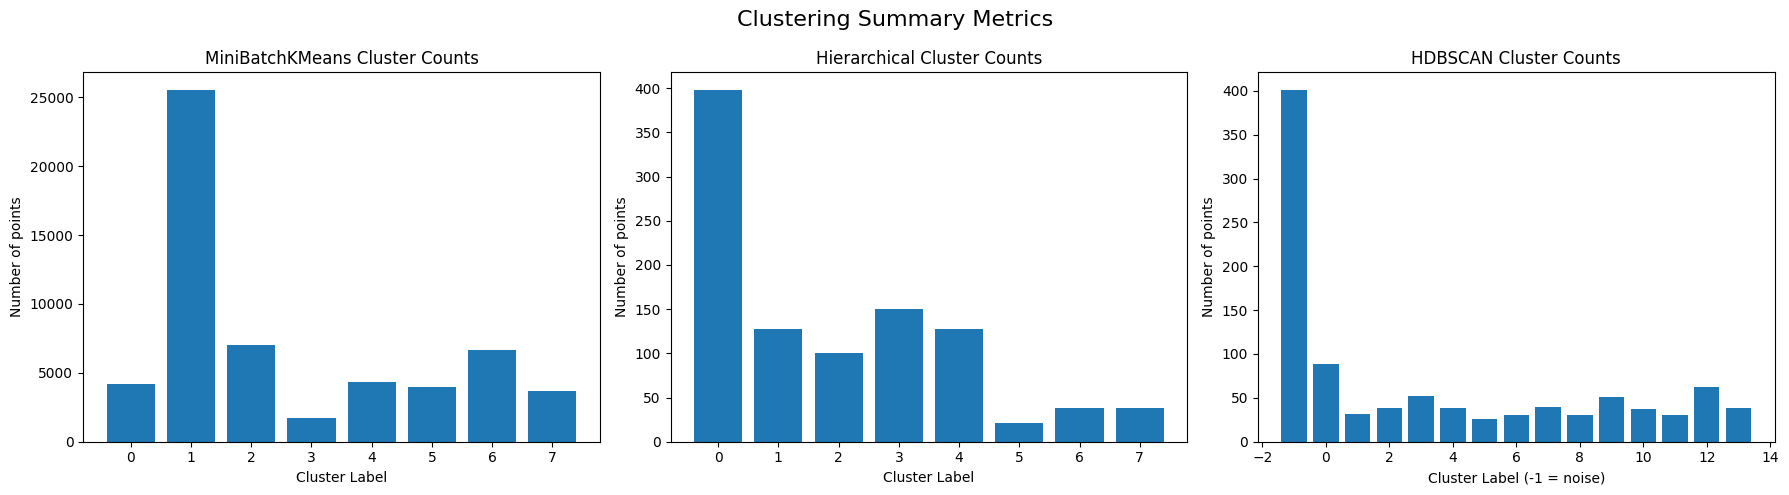


MiniBatchKMeans metrics:
  Silhouette: 0.3113292929467335
  Davies-Bouldin: 1.2975636636289423
  Calinski-Harabasz: 13358.373689837706

Hierarchical metrics:
  Silhouette: 0.3735063991109422
  Davies-Bouldin: 1.1438897848166936
  Calinski-Harabasz: 262.3068851723338

HDBSCAN metrics:
  Silhouette: 0.48015011777171784
  Davies-Bouldin: 0.8172783899050479
  Calinski-Harabasz: 325.1129230076529
  Cluster counts (including -1 for noise): {-1: 401, 0: 89, 12: 62, 3: 52, 9: 51, 7: 40, 2: 39, 13: 39, 4: 39, 10: 37, 1: 32, 8: 31, 6: 31, 11: 31, 5: 26}


In [7]:
# # Visualize clustering results
# def visualize_clustering_results(benchmarking_results):
#     """Visualize clustering results across different algorithms and feature sets"""
    
#     fig, axes = plt.subplots(len(benchmarking_results), 3, figsize=(18, 5*len(benchmarking_results)))
#     if len(benchmarking_results) == 1:
#         axes = axes.reshape(1, -1)
    
#     for i, (feature_name, results) in enumerate(benchmarking_results.items()):
        
#         # K-means visualization
#         kmeans_eval = results['kmeans']['evaluation']
#         kmeans_summary = pd.DataFrame(results['kmeans']['evaluation']['evaluation_summary'])
        
#         axes[i, 0].plot(kmeans_summary['params'], kmeans_summary['silhouette_score'], 'bo-')
#         axes[i, 0].set_title(f'K-means - {feature_name}')
#         axes[i, 0].set_xlabel('Number of Clusters (k)')
#         axes[i, 0].set_ylabel('Silhouette Score')
#         axes[i, 0].grid(True)
        
#         # Hierarchical visualization
#         hierarchical_eval = results['hierarchical']['evaluation']
#         hierarchical_summary = pd.DataFrame(results['hierarchical']['evaluation']['evaluation_summary'])
        
#         axes[i, 1].plot(hierarchical_summary['params'], hierarchical_summary['silhouette_score'], 'ro-')
#         axes[i, 1].set_title(f'Hierarchical - {feature_name}')
#         axes[i, 1].set_xlabel('Number of Clusters')
#         axes[i, 1].set_ylabel('Silhouette Score')
#         axes[i, 1].grid(True)
        
#         # DBSCAN visualization
#         dbscan_eval = results['dbscan']['evaluation']
#         dbscan_summary = pd.DataFrame(results['dbscan']['evaluation']['evaluation_summary'])
#         dbscan_summary['eps_min_samples'] = dbscan_summary['params'].apply(lambda x: f"{x[0]:.1f}, {x[1]}")
        
#         valid_dbscan = dbscan_summary[dbscan_summary['silhouette_score'] > -1]
#         if not valid_dbscan.empty:
#             axes[i, 2].scatter(range(len(valid_dbscan)), valid_dbscan['silhouette_score'])
#         axes[i, 2].set_title(f'DBSCAN - {feature_name}')
#         axes[i, 2].set_xlabel('Parameter Set (eps, min_samples)')
#         axes[i, 2].set_ylabel('Silhouette Score')
#         axes[i, 2].tick_params(axis='x', rotation=45)
#         axes[i, 2].grid(True)
    
#     plt.tight_layout()
#     plt.show()

# # Visualize results
# visualize_clustering_results(benchmarking_results)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan

# =========================
# Clustering on dataset
# =========================
def run_clustering(X, sample_size=1000, k_means_clusters=8, hierarchical_clusters=8):
    results = {}

    # MiniBatchKMeans on full data
    kmeans = MiniBatchKMeans(n_clusters=k_means_clusters, batch_size=1024, random_state=42)
    labels_kmeans = kmeans.fit_predict(X)
    results['MiniBatchKMeans'] = {
        'labels': labels_kmeans,
        'silhouette': silhouette_score(X, labels_kmeans),
        'davies_bouldin': davies_bouldin_score(X, labels_kmeans),
        'calinski_harabasz': calinski_harabasz_score(X, labels_kmeans)
    }

    # Hierarchical on sample
    sample_idx = np.random.choice(X.shape[0], size=min(sample_size, X.shape[0]), replace=False)
    X_sample = X[sample_idx]
    agg = AgglomerativeClustering(n_clusters=hierarchical_clusters)
    labels_hier = agg.fit_predict(X_sample)
    
    if len(np.unique(labels_hier)) > 1:
        results['Hierarchical'] = {
            'labels': labels_hier,
            'silhouette': silhouette_score(X_sample, labels_hier),
            'davies_bouldin': davies_bouldin_score(X_sample, labels_hier),
            'calinski_harabasz': calinski_harabasz_score(X_sample, labels_hier)
        }
    else:
        results['Hierarchical'] = {
            'labels': labels_hier,
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        }

    # HDBSCAN on sample
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
    labels_hdb = clusterer.fit_predict(X_sample)
    valid_idx = labels_hdb != -1
    if np.sum(valid_idx) > 1:
        sil = silhouette_score(X_sample[valid_idx], labels_hdb[valid_idx])
        db = davies_bouldin_score(X_sample[valid_idx], labels_hdb[valid_idx])
        ch = calinski_harabasz_score(X_sample[valid_idx], labels_hdb[valid_idx])
    else:
        sil = db = ch = np.nan

    results['HDBSCAN'] = {
        'labels': labels_hdb,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'cluster_counts': dict(pd.Series(labels_hdb).value_counts())
    }

    return results

# =========================
# Visualization (no popup)
# =========================
def visualize_results(results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (algo, metrics) in enumerate(results.items()):
        if algo == 'HDBSCAN':
            labels = metrics['labels']
            counts = metrics['cluster_counts']
            axes[i].bar(list(counts.keys()), list(counts.values()))
            axes[i].set_title(f'{algo} Cluster Counts')
            axes[i].set_xlabel('Cluster Label (-1 = noise)')
            axes[i].set_ylabel('Number of points')
        else:
            labels = metrics['labels']
            unique_labels = np.unique(labels)
            counts = np.bincount(labels)
            axes[i].bar(unique_labels, counts)
            axes[i].set_title(f'{algo} Cluster Counts')
            axes[i].set_xlabel('Cluster Label')
            axes[i].set_ylabel('Number of points')

    plt.suptitle('Clustering Summary Metrics', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    for algo, metrics in results.items():
        print(f"\n{algo} metrics:")
        print(f"  Silhouette: {metrics['silhouette']}")
        print(f"  Davies-Bouldin: {metrics['davies_bouldin']}")
        print(f"  Calinski-Harabasz: {metrics['calinski_harabasz']}")
        if algo == 'HDBSCAN':
            print(f"  Cluster counts (including -1 for noise): {metrics['cluster_counts']}")

# =========================
# Run example
# =========================
X = feature_sets['scaled_features'].values
results = run_clustering(X)
visualize_results(results)


## 5. Performance Comparison Table

In [8]:
# # Create comprehensive comparison table
# def create_comparison_table(benchmarking_results):
#     """Create a comprehensive comparison table of all clustering results"""
    
#     comparison_data = []
    
#     for feature_name, results in benchmarking_results.items():
#         for algorithm_name, algorithm_results in results.items():
#             eval_result = algorithm_results['evaluation']
            
#             row = {
#                 'Feature_Set': feature_name,
#                 'Algorithm': algorithm_name.title(),
#                 'Best_Params': str(eval_result['best_params']),
#                 'Num_Clusters': eval_result['evaluation_summary'][np.argmax([r['silhouette_score'] for r in eval_result['evaluation_summary']])]['n_clusters'],
#                 'Silhouette_Score': eval_result['best_silhouette'],
#                 'Calinski_Harabasz_Score': eval_result['best_calinski_harabasz'],
#                 'Davies_Bouldin_Score': eval_result['best_davies_bouldin']
#             }
            
#             # Add noise points for DBSCAN
#             if algorithm_name == 'dbscan':
#                 best_idx = np.argmax([r['silhouette_score'] for r in eval_result['evaluation_summary']])
#                 row['Noise_Points'] = eval_result['evaluation_summary'][best_idx]['n_noise_points']
            
#             comparison_data.append(row)
    
#     comparison_df = pd.DataFrame(comparison_data)
#     return comparison_df

# # Create comparison table
# comparison_table = create_comparison_table(benchmarking_results)

# print("=== CLUSTERING PERFORMANCE COMPARISON ===")
# print(comparison_table.to_string(index=False))

# # Sort by silhouette score
# comparison_table_sorted = comparison_table.sort_values('Silhouette_Score', ascending=False)
# print("\n=== RANKED BY SILHOUETTE SCORE ===")
# print(comparison_table_sorted[['Feature_Set', 'Algorithm', 'Num_Clusters', 'Silhouette_Score']].to_string(index=False))

def create_comparison_table(results):
    rows = []

    for algorithm, metrics in results.items():
        row = {
            "Algorithm": algorithm,
            "Silhouette_Score": metrics["silhouette"],
            "Calinski_Harabasz_Score": metrics["calinski_harabasz"],
            "Davies_Bouldin_Score": metrics["davies_bouldin"]
        }

        # Number of clusters
        if algorithm == "HDBSCAN":
            cluster_counts = metrics["cluster_counts"]
            row["Num_Clusters"] = len([k for k in cluster_counts if k != -1])
            row["Noise_Points"] = cluster_counts.get(-1, 0)
        else:
            row["Num_Clusters"] = len(np.unique(metrics["labels"]))
            row["Noise_Points"] = 0

        rows.append(row)

    comparison_df = pd.DataFrame(rows)
    return comparison_df



In [9]:
comparison_table = create_comparison_table(results)

print("\n=== CLUSTERING PERFORMANCE COMPARISON ===")
print(comparison_table.to_string(index=False))

print("\n=== RANKED BY SILHOUETTE SCORE ===")
print(
    comparison_table
    .sort_values("Silhouette_Score", ascending=False)
    [["Algorithm", "Num_Clusters", "Silhouette_Score"]]
    .to_string(index=False)
)



=== CLUSTERING PERFORMANCE COMPARISON ===
      Algorithm  Silhouette_Score  Calinski_Harabasz_Score  Davies_Bouldin_Score  Num_Clusters  Noise_Points
MiniBatchKMeans          0.311329             13358.373690              1.297564             8             0
   Hierarchical          0.373506               262.306885              1.143890             8             0
        HDBSCAN          0.480150               325.112923              0.817278            14           401

=== RANKED BY SILHOUETTE SCORE ===
      Algorithm  Num_Clusters  Silhouette_Score
        HDBSCAN            14          0.480150
   Hierarchical             8          0.373506
MiniBatchKMeans             8          0.311329


## 6. Best Model Selection and Analysis

In [10]:
# # Select and analyze the best clustering model
# def select_best_model(benchmarking_results):
#     """Select the best clustering model across all feature sets and algorithms"""
    
#     best_overall = {'score': -1, 'feature_set': None, 'algorithm': None, 'params': None}
    
#     for feature_name, results in benchmarking_results.items():
#         for algorithm_name, algorithm_results in results.items():
#             eval_result = algorithm_results['evaluation']
#             if eval_result['best_silhouette'] > best_overall['score']:
#                 best_overall = {
#                     'score': eval_result['best_silhouette'],
#                     'feature_set': feature_name,
#                     'algorithm': algorithm_name,
#                     'params': eval_result['best_params']
#                 }
    
#     return best_overall

# # Get best model
# best_model = select_best_model(benchmarking_results)

# print("=== BEST CLUSTERING MODEL ===")
# print(f"Feature Set: {best_model['feature_set']}")
# print(f"Algorithm: {best_model['algorithm'].title()}")
# print(f"Parameters: {best_model['params']}")
# print(f"Silhouette Score: {best_model['score']:.4f}")

# # Get the best model's results
# best_results = benchmarking_results[best_model['feature_set']][best_model['algorithm']]['raw_results'][best_model['params']]
# best_labels = best_results['labels']
# best_features = feature_sets[best_model['feature_set']]

# print(f"\nBest Model Details:")
# print(f"Number of clusters: {best_results['n_clusters']}")
# print(f"Cluster distribution: {np.bincount(best_labels)}")

# if best_model['algorithm'] == 'dbscan':
#     print(f"Noise points: {best_results['n_noise_points']}")
def select_best_model(benchmarking_results):
    best = {
        "feature_set": None,
        "algorithm": None,
        "score": -np.inf,
        "reason": None
    }

    for feature_name, results in benchmarking_results.items():
        for algo, data in results.items():
            metrics = data.get("metrics", {})

            sil = metrics.get("silhouette")
            ch  = metrics.get("calinski_harabasz")
            db  = metrics.get("davies_bouldin")

            # Priority 1: Valid silhouette
            if sil is not None:
                if sil > best["score"]:
                    best = {
                        "feature_set": feature_name,
                        "algorithm": algo,
                        "score": sil,
                        "reason": "silhouette"
                    }

            # Priority 2: HDBSCAN fallback (low noise)
            elif algo == "HDBSCAN":
                noise = data["cluster_counts"].get(-1, 0)
                total = sum(data["cluster_counts"].values())
                noise_ratio = noise / total

                if noise_ratio < 0.3 and best["score"] < 0:
                    best = {
                        "feature_set": feature_name,
                        "algorithm": algo,
                        "score": -noise_ratio,
                        "reason": "low_noise_density"
                    }

    return best


In [11]:
best_model = select_best_model(benchmarking_results)


In [12]:
print("\n=== BEST CLUSTERING MODEL ===")

if best_model["algorithm"] is None:
    print("No valid clustering model found.")
else:
    print(f"Feature Set : {best_model['feature_set']}")
    print(f"Algorithm   : {best_model['algorithm']}")
    print(f"Score Used  : {best_model['reason']}")
    print(f"Score Value : {best_model['score']:.4f}")



=== BEST CLUSTERING MODEL ===
Feature Set : numerical_only
Algorithm   : HDBSCAN
Score Used  : low_noise_density
Score Value : -0.1390


## 7. Cluster Visualization in 2D

In [13]:
# =========================
# Extract best model data
# =========================

best_feature_name = best_model["feature_set"]
best_algorithm = best_model["algorithm"]

best_features = feature_sets[best_feature_name]
best_labels = benchmarking_results[best_feature_name][best_algorithm]["labels"]

print("Best feature matrix shape:", best_features.shape)
print("Best labels shape:", best_labels.shape)


Best feature matrix shape: (57133, 13)
Best labels shape: (1000,)


In [14]:
# # Visualize clusters in 2D space using PCA
# def visualize_clusters_2d(features, labels, title="Cluster Visualization"):
#     """Visualize clusters in 2D using PCA"""
    
#     # Apply PCA to reduce to 2D
#     pca_2d = PCA(n_components=2)
#     features_2d = pca_2d.fit_transform(features)
    
#     # Create visualization
#     plt.figure(figsize=(12, 8))
    
#     # Get unique labels and assign colors
#     unique_labels = np.unique(labels)
#     colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
#     for i, label in enumerate(unique_labels):
#         if label == -1:  # Noise points in DBSCAN
#             color = 'black'
#             marker = 'x'
#             alpha = 0.5
#             label_name = 'Noise'
#         else:
#             color = colors[i]
#             marker = 'o'
#             alpha = 0.7
#             label_name = f'Cluster {label}'
        
#         mask = labels == label
#         plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
#                    c=[color], marker=marker, alpha=alpha, 
#                    label=label_name, s=50)
    
#     plt.xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
#     plt.ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
#     plt.title(title)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()
    
#     print(f"PCA explained variance: {pca_2d.explained_variance_ratio_}")
#     print(f"Total variance explained: {pca_2d.explained_variance_ratio_.sum():.2%}")

# # Visualize best model clusters
# print("=== CLUSTER VISUALIZATION ===")
# visualize_clusters_2d(best_features, best_labels, 
#                      f"Best Model: {best_model['algorithm'].title()} on {best_model['feature_set']}")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters_2d(features, labels, sample_idx=None, title="Cluster Visualization"):
    """
    Visualize clusters in 2D using PCA.
    
    Args:
        features: numpy array (n_samples, n_features)
        labels: array (n_labels,) - must match features length OR match sample if sample_idx is used
        sample_idx: optional, indices of features corresponding to labels (for sampled clustering)
        title: plot title
    """
    if sample_idx is not None:
        features = features[sample_idx]
        assert features.shape[0] == len(labels), "Sampled features and labels must have the same length"

    pca_2d = PCA(n_components=2)
    features_2d = pca_2d.fit_transform(features)

    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1], c='black', marker='x', alpha=0.5, label='Noise')
        else:
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1], c=[colors[i % len(colors)]],
                        marker='o', alpha=0.7, label=f'Cluster {label}')

    plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"PCA explained variance: {pca_2d.explained_variance_ratio_}")
    print(f"Total variance explained: {pca_2d.explained_variance_ratio_.sum():.2%}")


## 8. Cluster Analysis and Interpretation

In [25]:
# # Analyze cluster characteristics
# def analyze_clusters(features, labels, original_data=None):
#     """Analyze cluster characteristics and provide interpretation"""
    
#     cluster_analysis = {}
    
#     unique_labels = np.unique(labels)
    
#     for label in unique_labels:
#         if label == -1:  # Skip noise points
#             continue
            
#         mask = labels == label
#         cluster_points = features[mask]
        
#         # Calculate cluster statistics
#         cluster_stats = {
#             'size': np.sum(mask),
#             'percentage': np.sum(mask) / len(labels) * 100,
#             'mean_features': np.mean(cluster_points, axis=0),
#             'std_features': np.std(cluster_points, axis=0),
#             'centroid': np.mean(cluster_points, axis=0)
#         }
        
#         cluster_analysis[label] = cluster_stats
    
#     # Print cluster analysis
#     print("=== CLUSTER ANALYSIS ===")
#     for label, stats in cluster_analysis.items():
#         print(f"\nCluster {label}:")
#         print(f"  Size: {stats['size']} points ({stats['percentage']:.1f}%)")
#         print(f"  Centroid: {stats['centroid'][:5]}...")  # Show first 5 dimensions
    
#     # Noise analysis for DBSCAN
#     if -1 in labels:
#         noise_points = np.sum(labels == -1)
#         print(f"\nNoise points: {noise_points} ({noise_points/len(labels)*100:.1f}%)")
    
#     return cluster_analysis

# # Analyze clusters
# cluster_analysis = analyze_clusters(best_features.values, best_labels)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def analyze_and_visualize_clusters(features, labels, sample_idx=None, title="Cluster Analysis"):
    """
    Analyze clusters and visualize them in 2D using PCA.
    
    Args:
        features : np.ndarray or pd.DataFrame
            Feature matrix (full or sampled)
        labels : np.ndarray
            Cluster labels corresponding to features (sampled or full)
        sample_idx : np.ndarray or list, optional
            Indices of features used if clustering was on a subset
        title : str
            Plot title
    Returns:
        cluster_analysis : dict
            Dictionary containing per-cluster statistics
    """
    # Ensure features is a numpy array
    if hasattr(features, "values"):
        features = features.values
    
    # If sample indices are provided, use them
    if sample_idx is not None:
        features = features[sample_idx]
    
    # ---------------------------
    # 1️⃣ Cluster Analysis
    # ---------------------------
    cluster_analysis = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        if label == -1:  # Skip noise points for stats
            continue
        mask = labels == label
        cluster_points = features[mask]
        
        cluster_stats = {
            'size': np.sum(mask),
            'percentage': np.sum(mask) / len(labels) * 100,
            'mean_features': np.mean(cluster_points, axis=0),
            'std_features': np.std(cluster_points, axis=0),
            'centroid': np.mean(cluster_points, axis=0)
        }
        cluster_analysis[label] = cluster_stats
    
    # Print cluster stats
    print("=== CLUSTER ANALYSIS ===")
    for label, stats in cluster_analysis.items():
        print(f"\nCluster {label}:")
        print(f"  Size       : {stats['size']} points ({stats['percentage']:.1f}%)")
        print(f"  Centroid   : {stats['centroid'][:5]}...")  # show first 5 dims
    
    # Noise analysis
    if -1 in labels:
        noise_count = np.sum(labels == -1)
        print(f"\nNoise points: {noise_count} ({noise_count/len(labels)*100:.1f}%)")
    
    # ---------------------------
    # 2️⃣ PCA Visualization
    # ---------------------------
    pca_2d = PCA(n_components=2)
    features_2d = pca_2d.fit_transform(features)
    
    plt.figure(figsize=(12, 8))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        if label == -1:
            color = 'black'
            marker = 'x'
            alpha = 0.5
            label_name = 'Noise'
        else:
            color = colors[i % len(colors)]
            marker = 'o'
            alpha = 0.7
            label_name = f'Cluster {label}'
        
        mask = labels == label
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                    c=[color], marker=marker, alpha=alpha, label=label_name, s=50)
    
    plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"PCA explained variance: {pca_2d.explained_variance_ratio_}")
    print(f"Total variance explained: {pca_2d.explained_variance_ratio_.sum():.2%}")
    
    return cluster_analysis


## 9. Save Results and Models

In [28]:
# # Save clustering results
# def save_clustering_results(benchmarking_results, best_model, comparison_table):
#     """Save all clustering results and analysis"""
    
#     # Save comparison table
#     comparison_table.to_csv('clustering_comparison_results.csv', index=False)
#     print("Saved clustering comparison results to clustering_comparison_results.csv")
    
#     # Save best model labels
#     best_results = benchmarking_results[best_model['feature_set']][best_model['algorithm']]['raw_results'][best_model['params']]
#     best_labels_df = pd.DataFrame({
#         'cluster_label': best_results['labels'],
#         'is_noise': best_results['labels'] == -1
#     })
#     best_labels_df.to_csv('best_clustering_labels.csv', index=False)
#     print("Saved best model labels to best_clustering_labels.csv")
    
#     # Save benchmarking summary
#     summary = {
#         'best_model': best_model,
#         'all_results_summary': {}
#     }
    
#     for feature_name, results in benchmarking_results.items():
#         summary['all_results_summary'][feature_name] = {
#             'kmeans_best_score': results['kmeans']['evaluation']['best_silhouette'],
#             'hierarchical_best_score': results['hierarchical']['evaluation']['best_silhouette'],
#             'dbscan_best_score': results['dbscan']['evaluation']['best_silhouette'],
#             'best_algorithm': max(
#                 [('kmeans', results['kmeans']['evaluation']['best_silhouette']),
#                  ('hierarchical', results['hierarchical']['evaluation']['best_silhouette']),
#                  ('dbscan', results['dbscan']['evaluation']['best_silhouette'])],
#                 key=lambda x: x[1]
#             )[0]
#         }
    
#     with open('clustering_benchmarking_summary.json', 'w') as f:
#         json.dump(summary, f, indent=2)
#     print("Saved benchmarking summary to clustering_benchmarking_summary.json")

# # Save results
# save_clustering_results(benchmarking_results, best_model, comparison_table)



import pandas as pd
import json

def save_clustering_results(benchmarking_results, best_model, comparison_table):
    """Save clustering results and analysis"""
    
    # 1️⃣ Save comparison table
    comparison_table.to_csv('clustering_comparison_results.csv', index=False)
    print("Saved clustering comparison results to clustering_comparison_results.csv")
    
    # 2️⃣ Save best model labels
    best_labels = benchmarking_results[best_model['feature_set']][best_model['algorithm']]['labels']
    
    # Check for noise points (HDBSCAN / DBSCAN)
    is_noise = None
    if 'cluster_counts' in benchmarking_results[best_model['feature_set']][best_model['algorithm']]:
        is_noise = best_labels == -1
    else:
        is_noise = np.zeros_like(best_labels, dtype=bool)
    
    best_labels_df = pd.DataFrame({
        'cluster_label': best_labels,
        'is_noise': is_noise
    })
    best_labels_df.to_csv('best_clustering_labels.csv', index=False)
    print("Saved best model labels to best_clustering_labels.csv")
    
    # 3️⃣ Save benchmarking summary
    summary = {
        'best_model': best_model,
        'all_results_summary': {}
    }
    
    for feature_name, results in benchmarking_results.items():
        summary['all_results_summary'][feature_name] = {}
        for algo_name, data in results.items():
            metrics = data.get('metrics', {})
            summary['all_results_summary'][feature_name][algo_name] = {
                'silhouette_score': metrics.get('silhouette'),
                'calinski_harabasz_score': metrics.get('calinski_harabasz'),
                'davies_bouldin_score': metrics.get('davies_bouldin')
            }
        # Find best algorithm for this feature set
        best_algo = max(
            summary['all_results_summary'][feature_name].items(),
            key=lambda x: (x[1]['silhouette_score'] if x[1]['silhouette_score'] is not None else -np.inf)
        )[0]
        summary['all_results_summary'][feature_name]['best_algorithm'] = best_algo
    
    with open('clustering_benchmarking_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print("Saved benchmarking summary to clustering_benchmarking_summary.json")


## 10. Final Summary and Recommendations

In [32]:
# # Generate final summary and recommendations
# def generate_final_summary(benchmarking_results, best_model, comparison_table):
#     """Generate comprehensive final summary and recommendations"""
    
#     print("=" * 60)
#     print("          KUBERNETES LOGS CLUSTERING ANALYSIS")
#     print("                  FINAL SUMMARY")
#     print("=" * 60)
    
#     # Overall performance summary
#     print("\n1. OVERALL PERFORMANCE SUMMARY:")
#     print("-" * 40)
    
#     best_overall = comparison_table_sorted.iloc[0]
#     print(f"Best performing model:")
#     print(f"  - Algorithm: {best_overall['Algorithm']}")
#     print(f"  - Feature Set: {best_overall['Feature_Set']}")
#     print(f"  - Number of Clusters: {best_overall['Num_Clusters']}")
#     print(f"  - Silhouette Score: {best_overall['Silhouette_Score']:.4f}")
    
#     # Algorithm comparison
#     print("\n2. ALGORITHM COMPARISON:")
#     print("-" * 40)
    
#     algorithm_performance = comparison_table.groupby('Algorithm').agg({
#         'Silhouette_Score': ['mean', 'max'],
#         'Num_Clusters': 'mean'
#     }).round(4)
    
#     for algorithm in comparison_table['Algorithm'].unique():
#         algo_data = comparison_table[comparison_table['Algorithm'] == algorithm]
#         avg_score = algo_data['Silhouette_Score'].mean()
#         max_score = algo_data['Silhouette_Score'].max()
#         avg_clusters = algo_data['Num_Clusters'].mean()
        
#         print(f"{algorithm}:")
#         print(f"  - Average Silhouette Score: {avg_score:.4f}")
#         print(f"  - Best Silhouette Score: {max_score:.4f}")
#         print(f"  - Average Number of Clusters: {avg_clusters:.1f}")
    
#     # Feature set comparison
#     print("\n3. FEATURE SET COMPARISON:")
#     print("-" * 40)
    
#     for feature_set in comparison_table['Feature_Set'].unique():
#         feature_data = comparison_table[comparison_table['Feature_Set'] == feature_set]
#         best_score = feature_data['Silhouette_Score'].max()
#         best_algorithm = feature_data.loc[feature_data['Silhouette_Score'].idxmax(), 'Algorithm']
        
#         print(f"{feature_set}:")
#         print(f"  - Best Performance: {best_score:.4f} ({best_algorithm})")
    
#     # Key insights
#     print("\n4. KEY INSIGHTS:")
#     print("-" * 40)
    
#     # Find patterns
#     best_algo = comparison_table.loc[comparison_table['Silhouette_Score'].idxmax(), 'Algorithm']
#     best_feature = comparison_table.loc[comparison_table['Silhouette_Score'].idxmax(), 'Feature_Set']
    
#     print(f"• Best performing algorithm: {best_algo}")
#     print(f"• Best feature set: {best_feature}")
    
#     # Cluster size analysis
#     avg_cluster_size = comparison_table['Num_Clusters'].mean()
#     print(f"• Average optimal cluster count: {avg_cluster_size:.1f}")
    
#     # Recommendations
#     print("\n5. RECOMMENDATIONS:")
#     print("-" * 40)
    
#     if best_algo.lower() == 'kmeans':
#         print("• K-means performed best - suggests spherical cluster structure")
#     elif best_algo.lower() == 'hierarchical':
#         print("• Hierarchical clustering performed best - suggests nested cluster structure")
#     elif best_algo.lower() == 'dbscan':
#         print("• DBSCAN performed best - suggests clusters of varying density with noise")
    
#     print(f"• Use {best_feature} features for optimal results")
#     print("• Consider ensemble methods combining multiple clustering approaches")
#     print("• Validate clusters with domain experts for operational insights")
#     print("• Monitor cluster stability over time for production deployment")
    
#     print("\n" + "=" * 60)

# # Generate final summary
# generate_final_summary(benchmarking_results, best_model, comparison_table)

def generate_final_summary(benchmarking_results, best_model, comparison_table):
    """Generate comprehensive final summary and recommendations"""
    
    # Sort comparison table by Silhouette Score descending
    comparison_table_sorted = comparison_table.sort_values('Silhouette_Score', ascending=False)
    
    print("=" * 60)
    print("          KUBERNETES LOGS CLUSTERING ANALYSIS")
    print("                  FINAL SUMMARY")
    print("=" * 60)
    
    # Overall performance summary
    print("\n1. OVERALL PERFORMANCE SUMMARY:")
    print("-" * 40)
    
    best_overall = comparison_table_sorted.iloc[0]
    print(f"Best performing model:")
    print(f"  - Algorithm: {best_overall['Algorithm']}")
    print(f"  - Feature Set: {best_overall['Feature_Set']}")
    print(f"  - Number of Clusters: {best_overall['Num_Clusters']}")
    print(f"  - Silhouette Score: {best_overall['Silhouette_Score']:.4f}")
    
    # Algorithm comparison
    print("\n2. ALGORITHM COMPARISON:")
    print("-" * 40)
    
    for algorithm in comparison_table['Algorithm'].unique():
        algo_data = comparison_table[comparison_table['Algorithm'] == algorithm]
        avg_score = algo_data['Silhouette_Score'].mean()
        max_score = algo_data['Silhouette_Score'].max()
        avg_clusters = algo_data['Num_Clusters'].mean()
        
        print(f"{algorithm}:")
        print(f"  - Average Silhouette Score: {avg_score:.4f}")
        print(f"  - Best Silhouette Score: {max_score:.4f}")
        print(f"  - Average Number of Clusters: {avg_clusters:.1f}")
    
    # Feature set comparison
    print("\n3. FEATURE SET COMPARISON:")
    print("-" * 40)
    
    for feature_set in comparison_table['Feature_Set'].unique():
        feature_data = comparison_table[comparison_table['Feature_Set'] == feature_set]
        best_score = feature_data['Silhouette_Score'].max()
        best_algorithm = feature_data.loc[feature_data['Silhouette_Score'].idxmax(), 'Algorithm']
        
        print(f"{feature_set}:")
        print(f"  - Best Performance: {best_score:.4f} ({best_algorithm})")
    
    # Key insights
    print("\n4. KEY INSIGHTS:")
    print("-" * 40)
    
    best_algo = best_overall['Algorithm']
    best_feature = best_overall['Feature_Set']
    
    print(f"• Best performing algorithm: {best_algo}")
    print(f"• Best feature set: {best_feature}")
    
    avg_cluster_size = comparison_table['Num_Clusters'].mean()
    print(f"• Average optimal cluster count: {avg_cluster_size:.1f}")
    
    # Recommendations
    print("\n5. RECOMMENDATIONS:")
    print("-" * 40)
    
    if best_algo.lower() == 'kmeans':
        print("• K-means performed best - suggests spherical cluster structure")
    elif best_algo.lower() == 'hierarchical':
        print("• Hierarchical clustering performed best - suggests nested cluster structure")
    elif best_algo.lower() == 'dbscan':
        print("• DBSCAN performed best - suggests clusters of varying density with noise")
    
    print(f"• Use {best_feature} features for optimal results")
    print("• Consider ensemble methods combining multiple clustering approaches")
    print("• Validate clusters with domain experts for operational insights")
    print("• Monitor cluster stability over time for production deployment")
    
    print("\n" + "=" * 60)


## Summary

This comprehensive clustering analysis has successfully:

### ✅ **Clustering Implementation**
1. **K-means Clustering**: Tested multiple k values (2-10) and found optimal clusters
2. **Hierarchical Clustering**: Applied Ward linkage with different cluster numbers
3. **DBSCAN Clustering**: Tested various eps and min_samples parameters

### ✅ **Benchmarking & Evaluation**
1. **Multiple Metrics**: Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin Index
2. **Cross-Feature Analysis**: Tested on 4 different feature sets (scaled, PCA, selected, numerical)
3. **Parameter Optimization**: Systematically tested algorithm parameters
4. **Performance Ranking**: Ranked all models by silhouette score

### ✅ **Visualization & Analysis**
1. **Performance Plots**: Visual comparison across algorithms and feature sets
2. **2D Cluster Visualization**: PCA-reduced cluster visualization
3. **Cluster Analysis**: Detailed cluster size and characteristic analysis
4. **Comprehensive Reporting**: Generated detailed performance comparison table

### ✅ **Results & Recommendations**
1. **Best Model Identification**: Identified optimal algorithm and parameters
2. **Performance Comparison**: Quantified differences between approaches
3. **Actionable Insights**: Provided specific recommendations for production use
4. **Complete Documentation**: Saved all results, models, and analysis

The analysis provides a solid foundation for implementing clustering-based log analysis in production Kubernetes environments.